In [131]:
import pymaster as nmt
import healpy as hp
import numpy as np

import pysm3
import pysm3.units as u

import matplotlib.pyplot as plt

import importlib

%matplotlib inline

In [162]:
import seaborn as sea
sea.set(rc={'figure.figsize':(11.7,8.27)})
sea.set_style("white")
sea.set_context("talk")
sea.set_style("ticks")

In [10]:
Nside = 128

In [198]:
mask_spass_256 = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_spass_256.npy')
mask_128 = hp.ud_grade(mask_spass_1024, nside_out=128)
mask_128 = np.logical_not(np.logical_not(mask_128))

In [241]:
len(mask_128)

196608

196608

In [199]:
mask_apo = nmt.mask_apodization(mask_128, 6, apotype='C2')

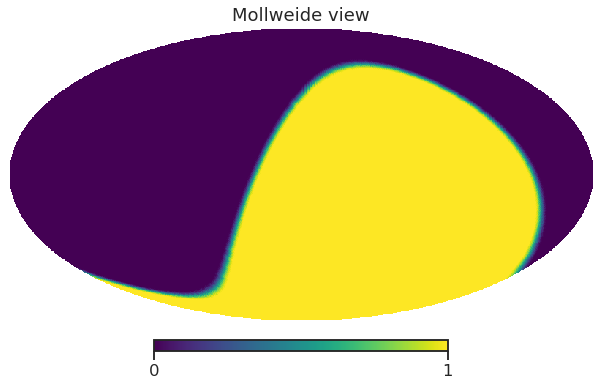

In [200]:
hp.mollview(mask_apo, cmap = 'viridis')

In [24]:
sky = pysm3.Sky(nside=Nside, preset_strings=["s0"])
maps = sky.get_emission(30 * u.GHz)

/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/synch_t_new.fits
  warnings.warn(f"Access data from {full_path}")
/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/synch_q_new.fits
  warnings.warn(f"Access data from {full_path}")
/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /global/project/projectdirs/cmb/www/pysm-data/pysm_2/synch_u_new.fits
  warnings.warn(f"Access data from {full_path}")


In [25]:
sl = hp.anafast(maps) #TT, EE, BB, TE, EB, TB

In [26]:
sl.shape

(6, 384)

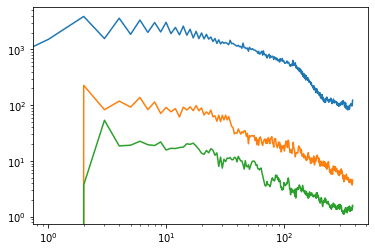

In [87]:
ell = np.arange(len(sl[0]))
plt.loglog(ell, ell*(ell+1)/2/np.pi*sl[0])
plt.loglog(ell, ell*(ell+1)/2/np.pi*sl[1])
plt.loglog(ell, ell*(ell+1)/2/np.pi*sl[2])

In [90]:
sl_fake_TT = (1e5*ell[1:].astype(float)**(-2.7))
sl_fake_EE = (3*1e3*ell[1:].astype(float)**(-2.7))
sl_fake_BB = (0.5*1e3*ell[1:].astype(float)**(-2.7))

Text(0.5, 1.0, 'Cl of pure synchrotron at 30GHz')

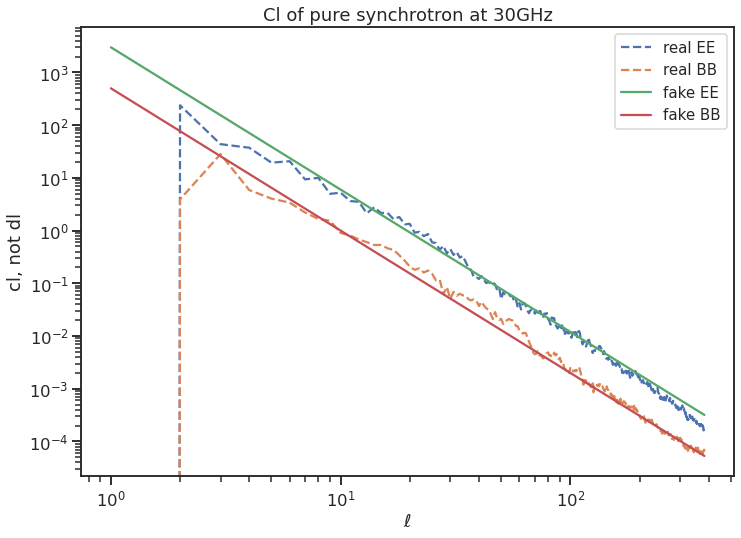

In [226]:
# plt.loglog(ell, sl[0])
plt.loglog(ell, sl[1], '--', label = 'real EE')
plt.loglog(ell, sl[2], '--', label = 'real BB')

# plt.loglog(ell[1:], sl_fake_TT)
plt.loglog(ell[1:], sl_fake_EE, label = 'fake EE')
plt.loglog(ell[1:], sl_fake_BB, label = 'fake BB')
plt.legend(fontsize = 15)

plt.xlabel('$\ell$')
plt.ylabel('cl, not dl')

plt.title('Cl of pure synchrotron at 30GHz')

# Full-sky, hp.anafast

In [227]:
sl_fake = np.array((sl_fake_TT, sl_fake_EE, sl_fake_BB, np.zeros_like(sl_fake_TT)))
sync_maps = hp.synfast(sl_fake, nside = Nside, new = True)

In [228]:
sl_hat = hp.anafast(sync_maps)

Text(0, 0.5, 'cl, not dl')

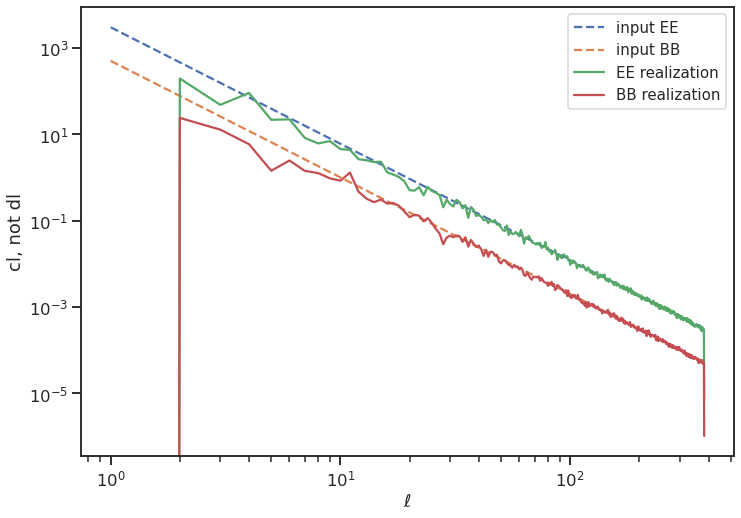

In [233]:
# plt.loglog(ell, sl[0])
# plt.loglog(ell, sl[1])
# plt.loglog(ell, sl[2])

# plt.loglog(ell[1:], sl_fake_TT)
plt.loglog(ell[1:], sl_fake_EE, '--', label = 'input EE')
plt.loglog(ell[1:], sl_fake_BB, '--', label = 'input BB')

# plt.loglog(ell, sl_hat[0])
plt.loglog(ell, sl_hat[1], label = 'EE realization')
plt.loglog(ell, sl_hat[2], label = 'BB realization')
plt.legend(fontsize = 15)

plt.xlabel('$\ell$')
plt.ylabel('cl, not dl')

# partial sky, Namaster

In [143]:
import bandpowers
importlib.reload(bandpowers)

<module 'bandpowers' from '/global/u2/j/jianyao/foreground/bandpowers.py'>

In [144]:
from BP_beam_nmt_bin import BPE as BPE_beam
from bandpowers import BPE as BPE

In [146]:
est = BPE(mask_128, Nside, 20, 300)

In [235]:
len(est.ell_n)

14

## one map

In [150]:
dl_all = est.Auto_TEB(sync_maps) #TT TE TB EE EB BB.
EE = dl_all[3]; BB = dl_all[5]

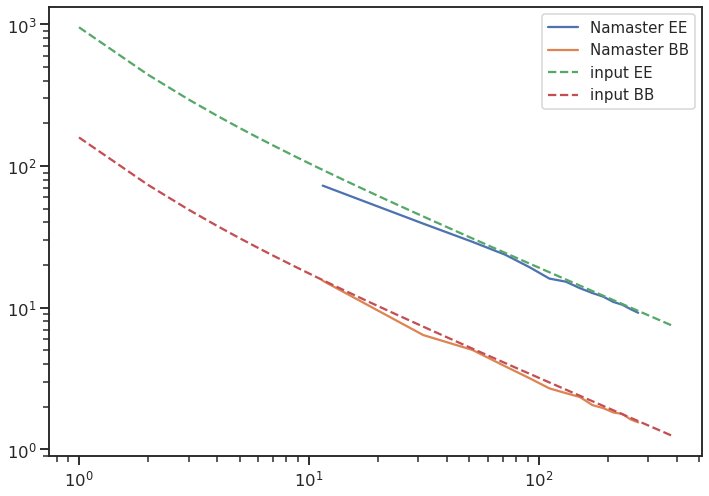

In [164]:
plt.loglog(est.ell_n, EE, label = 'Namaster EE')
plt.loglog(est.ell_n, BB, label = 'Namaster BB')

plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_EE, '--',label = 'input EE')
plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_BB, '--',label = 'input BB')
plt.legend(fontsize = 15)

plt.xlabel('$\ell$')
plt.ylabel('Dl')

## 50 maps

In [165]:
EEs = []; BBs = []
for i in range(50):
    sync_maps_i = hp.synfast(sl_fake, nside = Nside, new = True)
    dl_all = est.Auto_TEB(sync_maps_i) #TT TE TB EE EB BB.
    EEs.append(dl_all[3]); BBs.append(dl_all[5])

In [166]:
EEs = np.array((EEs));BBs = np.array((BBs));

In [170]:
EE_mean = np.mean(EEs, axis = 0)
EE_std = np.std(EEs, axis = 0)
BB_mean = np.mean(BBs, axis = 0)
BB_std = np.std(BBs, axis = 0)

In [174]:
BB_std

array([2.86233424, 0.3862511 , 0.19584326, 0.15081334, 0.11844633,
       0.07943103, 0.05959578, 0.05416717, 0.05000915, 0.0541737 ,
       0.04086276, 0.03804988, 0.03382354, 0.03602194])

In [236]:
# plt.errorbar(est.ell_n, EE_mean, EE_std, label = 'Namaster EE')
# plt.errorbar(est.ell_n, BB_mean, BB_std, label = 'Namaster BB')

plt.loglog(est.ell_n, EE_mean, 'o-', label = 'Namaster EE')
plt.loglog(est.ell_n, BB_mean,'o-', label = 'Namaster BB')
plt.fill_between(est.ell_n, EE_mean - EE_std, EE_mean + EE_std, alpha=0.5)
plt.fill_between(est.ell_n, BB_mean - BB_std, BB_mean + BB_std, alpha=0.5)

plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_EE, '--',label = 'input EE')
plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_BB, '--',label = 'input BB')
plt.legend(fontsize = 15)

# Overlapped region

In [205]:
mask_cbass_256 = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_cbass_256.npy')

mask_both = hp.ud_grade(mask_cbass_256*mask_spass_256, nside_out=128)
mask_both = np.logical_not(np.logical_not(mask_both))

In [246]:
mask_both.sum()/(12*128**2)

0.12993876139322916

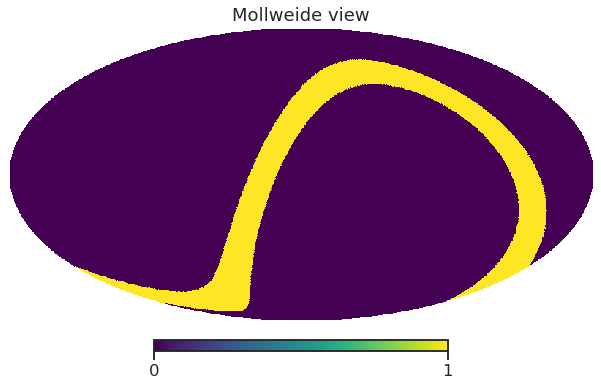

In [247]:
hp.mollview(mask_both, cmap = 'viridis')

In [210]:
est_both = BPE(mask_both, Nside, 20, 300)

EEs = []; BBs = []
for i in range(50):
    sync_maps_i = hp.synfast(sl_fake, nside = Nside, new = True)
    dl_all = est_both.Auto_TEB(sync_maps_i) #TT TE TB EE EB BB.
    EEs.append(dl_all[3]); BBs.append(dl_all[5])
    
EEs = np.array((EEs));BBs = np.array((BBs));

EE_mean = np.mean(EEs, axis = 0); EE_std = np.std(EEs, axis = 0)
BB_mean = np.mean(BBs, axis = 0); BB_std = np.std(BBs, axis = 0)

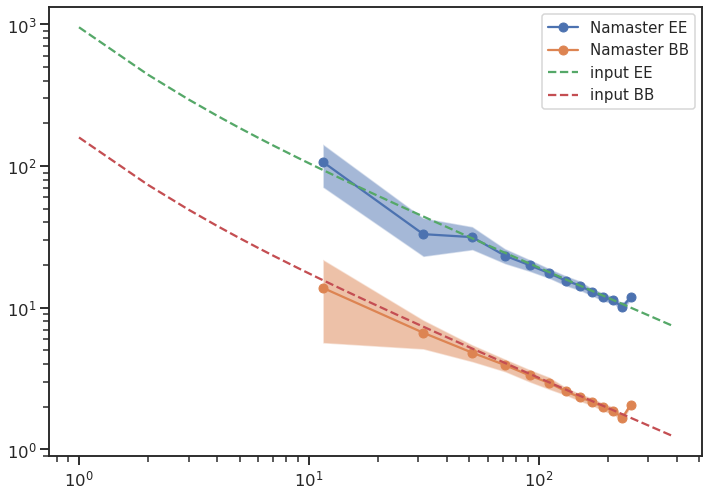

In [239]:
# plt.errorbar(est.ell_n, EE_mean, EE_std, label = 'Namaster EE')
# plt.errorbar(est.ell_n, BB_mean, BB_std, label = 'Namaster BB')

plt.loglog(est_both.ell_n, EE_mean, 'o-', label = 'Namaster EE')
plt.loglog(est_both.ell_n, BB_mean, 'o-', label = 'Namaster BB')
plt.fill_between(est_both.ell_n, EE_mean - EE_std, EE_mean + EE_std, alpha=0.5)
plt.fill_between(est_both.ell_n, BB_mean - BB_std, BB_mean + BB_std, alpha=0.5)

plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_EE, '--',label = 'input EE')
plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_BB, '--',label = 'input BB')
plt.legend(fontsize = 15)

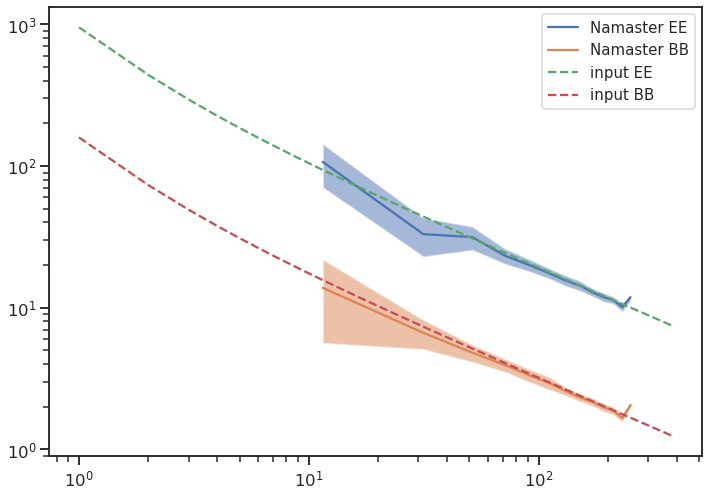

In [218]:
est_both = BPE(mask_both, Nside, 20, 280)

EEs = []; BBs = []
for i in range(50):
    sync_maps_i = hp.synfast(sl_fake, nside = Nside, new = True)
    dl_all = est_both.Auto_TEB(sync_maps_i) #TT TE TB EE EB BB.
    EEs.append(dl_all[3]); BBs.append(dl_all[5])
    
EEs = np.array((EEs));BBs = np.array((BBs));

EE_mean = np.mean(EEs, axis = 0); EE_std = np.std(EEs, axis = 0)
BB_mean = np.mean(BBs, axis = 0); BB_std = np.std(BBs, axis = 0)

# plt.errorbar(est.ell_n, EE_mean, EE_std, label = 'Namaster EE')
# plt.errorbar(est.ell_n, BB_mean, BB_std, label = 'Namaster BB')

plt.loglog(est_both.ell_n, EE_mean, label = 'Namaster EE')
plt.loglog(est_both.ell_n, BB_mean, label = 'Namaster BB')
plt.fill_between(est_both.ell_n, EE_mean - EE_std, EE_mean + EE_std, alpha=0.5)
plt.fill_between(est_both.ell_n, BB_mean - BB_std, BB_mean + BB_std, alpha=0.5)

plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_EE, '--',label = 'input EE')
plt.loglog(ell[1:], ell[1:]*(ell[1:]+1)/2/np.pi*sl_fake_BB, '--',label = 'input BB')
plt.legend(fontsize = 15)

# A circular region

In [249]:
from NPTFit import create_mask as cm # Module for creating masks

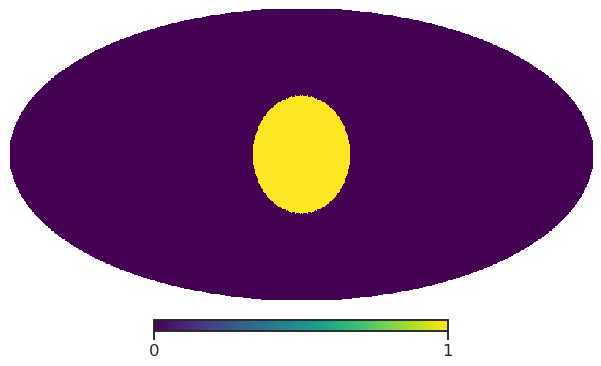

In [254]:
mask_cir = cm.make_mask_total(mask_ring = True, inner = 30, outer = 180, ring_b = 0, ring_l = 0)
hp.mollview(mask_cir,title='', cmap = 'viridis')